In [1]:
import numpy as np
import copy

import warnings
warnings.filterwarnings("ignore")

## Direct methods

In [31]:
def gauss_jordan(A, b):
    
    n = len(b)
    X = []
    zer = np.zeros((n, n + 1))
    zer[:, 0:n] = A
    zer[:, n] = b
    
    for i in range(n):
        if zer[i, i] == 0:
            for j in range(i + 1, n):
                if zer[j, i] != 0:
                    zer[i, :] = zer[i, :] + zer[j, :]
                    break
            
        if zer[i, i] == 0:
            raise Exception('The matrix is degenerate')
        
        zer[i, :] = zer[i, :] / zer[i, i]
        for j in range(n):
            if i != j:
                zer[j, :] = zer[j, :] - zer[i, :] * zer[j, i]
        X = zer[:, n]
    
    return X
        

In [3]:
def cramer(A, b):
    det_A = np.linalg.det(A)
    n = len(b)
    X = np.zeros(n)
    
    for k in range(n):
        min_k = A.copy()
        min_k[:, k] = b
        det_min_k = np.linalg.det(min_k)
        X[k] = det_min_k / det_A
        
    return X

In [4]:
def get_cholesky(A):
        
    L = np.zeros_like(A)
    n, _ = np.shape(A)
    
    for j in range(n):
        for i in range(j, n):
            if i == j:
                L[i, j] = np.sqrt(A[i, j] - np.sum(L[i, :j] ** 2))
            else:
                L[i, j] = (A[i, j] - np.sum(L[i, :j] * L[j, :j])) / L[j, j]
    return L

def cholesky(L, Lt, b):
    n, _ = np.shape(L)
    y, X = np.zeros(n), np.zeros(n)
    
    for i in range(n):
        y[i] = (b[i] - np.sum(L[i, :i] * y[:i])) / L[i, i]

        
    for i in range(n-1, -1, -1):
        X[i] = (y[i] - np.sum(Lt[i, i+1:n] * X[i+1:n])) / Lt[i, i]
    
    return X

## Iteration methods

In [5]:
accuracy = (10) ** (-10)
k_max = 200
w = 1.5

In [51]:
def jacobi(A, b):
    
    global accuracy, k_max
    
    len_b = len(b)
    R = A
    D = np.zeros(len_b)
    X = np.zeros((len_b, 1))
    k = 0
    
    while k < k_max:
        prev_X = X
        for i in range(len_b):
            sm = 0
            for j in range(len_b):
                if i != j:
                    sm += A[i, j] * X[j, 0]
                    
            X[i, 0] = (b[i] - sm) / X[j, 0]
        
        if np.linalg.norm(X - prev_X) < accuracy:
            break
        
        k += 1

    return X  

In [52]:
def gauss_seidel(A, b):
    global k_max, accuracy
    
    n = len(A)
    prev_X = np.zeros((n, 1))
    X = np.zeros((n, 1))
    k = 0
    
    while k < k_max:
        for i in range(n):
            sm = 0
            for j in range(0, i - 1):
                sm += A[i, j] * prev_X[j]
            for j in range(i + 1, n):
                sm += A[i, j] * X[j]
            prev_X[i] = (b[i] - sm) / A[i, i]
        
        k += 1
        X = prev_X
        if np.linalg.norm(X - prev_X) < accuracy:
            break
    
    return X

In [71]:
def relaxation(A, b):

    global accuracy, k_max, w
    
    len_b = len(b)
    D, R, L, X = np.zeros((len_b, len_b)), np.zeros((len_b, len_b)), np.zeros((len_b, len_b)), np.zeros((len_b, 1))
    k = 0
    
    for i in range(len_b):
        for j in range(len_b):
            if i == j: D[i, i] = A[i, i]
            elif i > j: L[i, j] = A[i, j]
            else: R[i, j] = A[i, j]
    
    while k < k_max:
        prev_X = X
        X = np.linalg.inv(L + D) @ (b - R @ X)
        X = prev_X + w * (X - prev_X)
        if np.linalg.norm(X - prev_X) < accuracy:
            break
        k += 1
            
    return X

## Getting run time

In [53]:
import time

In [54]:
direct_times = {'Gauss-Jordan method': [], 'Cramer method': [], 'Cholesky method' : []}
siz = [x for x in range(100, 501, 100)] 

In [ ]:
for size in siz:
    
    R, b = np.random.randint(-15, 15, size=(size, size)), np.random.randint(-20, 20, size=size)
    A = (R + R.T) / 2
    
    for method in list(direct_times.keys())[:-1]:
        meth = method.split(' ')[0].lower().replace('-', '_')
        start_time = time.time()
        eval(meth)(A, b)
        direct_times[method].append(time.time() - start_time)
    
    start_time = time.time()
    L = get_cholesky(A)
    Lt = L.T
    cholesky(L, Lt, b)
    direct_times['Cholesky method'].append(time.time() - start_time)

## Plotting

In [46]:
import matplotlib
import matplotlib.pyplot as plt

### Direct methods

In [47]:
colors = ['pink', 'navy', 'blueviolet']

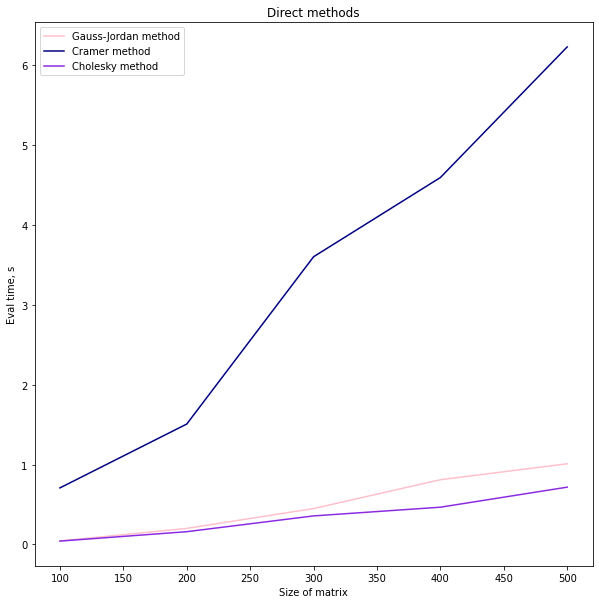

In [48]:
plt.figure(figsize=(10, 10))
plt.title('Direct methods')
plt.xlabel('Size of matrix')
plt.ylabel('Eval time, s')

for method in direct_times.keys():
    plt.plot(siz, direct_times[method], color=colors.pop(0), label=method)

plt.legend()

### Iteration methods

In [74]:
iter_times = {'Jacobi method': [], 'Gauss-Seidel method': [], 'Relaxation method': []}

In [75]:
for size in siz:
    
    R, b = np.random.randint(-15, 15, size=(size, size)), np.random.randint(-20, 20, size=size)
    A = R @ R.T + np.ones((size, size)) * size ** 3
    
    for method in list(iter_times.keys()):
        meth = method.split(' ')[0].lower().replace('-', '_')
        start_time = time.time()
        eval(meth)(A, b)
        iter_times[method].append(time.time() - start_time)

In [76]:
colors = ['navy', 'darksalmon', 'green']

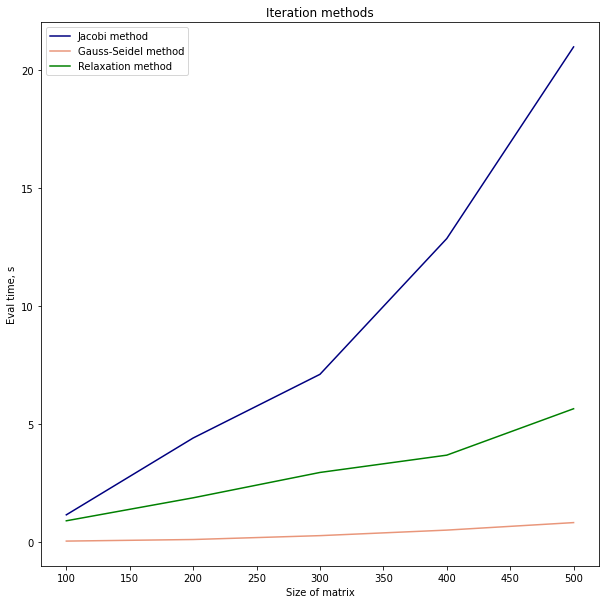

In [77]:
plt.figure(figsize=(10, 10))
plt.title('Iteration methods')
plt.xlabel('Size of matrix')
plt.ylabel('Eval time, s')

for method in iter_times.keys():
    plt.plot(siz, iter_times[method], color=colors.pop(0), label=method)

plt.legend()